In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from bokeh.models import ColumnDataSource, Legend, Rect, LegendItem, Span, Arrow, NormalHead, OpenHead, VeeHead
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.layouts import gridplot, layout, Spacer
import os


from bokeh.models import BoxAnnotation, Label, InvertedTriangle, Text, Triangle
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import show
from bokeh.embed import components

from sklearn import preprocessing
from statsmodels.nonparametric.smoothers_lowess import lowess

Defining functions for reading and manipulating data

In [79]:
def CovidRelated(title_string):
    covid_tags = ['coronavirus', 'covid', 'quarantine','c19','c-19',
                  'pandemic', 'virus', 'epidemic', 'lockdown','sars', 'CoV-2']
    covid_in_title = [x in title_string for x in covid_tags]
    return int(sum(covid_in_title) > 0)

def get_list_of_subreddits(topic, n=3):
    
    topic_path = ('./lists/List_of_{0}_subreddits.txt').format(topic)
    f = open(topic_path, 'r')
    topic_list = f.readlines()
    f.close()
    topic_list = [x[:-1].split(' ') for x in topic_list]
    topic_list = [item for sublist in topic_list for item in sublist]
    topic_list = [x[n:].lower() for x in topic_list]
    
    return topic_list


def GetData(w,sr,folder='weeks', year = '2020', N = None, categories = None):
    
    column_names = ['time_utc', 'epoch_utc', 'time_local', 'epoch_local', 'id', 'score', 'subreddit', 'ncomments']

    t_i = str(w)
    subreddit = sr
    parent_folder = './subreddits/'
    parent_folder = './{0}/subreddits/'.format(year)
    titles_file_name = parent_folder + subreddit +'/' + folder +'/'+ t_i +'/titles.txt'
    df_file_name = parent_folder + subreddit + '/' + folder +'/'+ t_i +'/df.txt'

    with open(titles_file_name,'r') as f:
        titles = f.readlines()

    data = pd.read_csv(df_file_name, sep="\t", header=None)

    data = data.rename(columns = dict(zip(range(8) , column_names)))
    data['title'] = [x.lower() for x in titles]

    data['time_utc'] = pd.to_datetime(data['time_utc'], infer_datetime_format=True)
    data['date_char'] = data['time_utc'].map(lambda x: str(x.day) + '/' + str(x.month))
    data = data.rename(columns = dict(zip(range(8) , column_names)))
    
    data['time_utc'] = pd.to_datetime(data['time_utc'], infer_datetime_format=True)
    data['time_local'] = pd.to_datetime(data['time_local'], infer_datetime_format=True)
    data['date_char'] = data['time_utc'].map(lambda x: str(x.day) + '/' + str(x.month))
    data['Month'] = data['time_utc'].map(lambda x: x.month)
    data['Year'] = data['time_utc'].map(lambda x: x.year)
    data['Hour'] = data['time_utc'].map(lambda x: x.hour)
    data['Day'] = data['time_utc'].map(lambda x: x.day)
    data['WeekDay'] = data['time_utc'].map(lambda x: x.dayofweek)
    data['WeekHour'] = (24*(data.WeekDay) + data.Hour)

    data['subreddit'] = [x.lower() for x in data['subreddit'].tolist()]

    # counting the days since the begining of the year
    ini_year = pd.to_datetime('2020-01-01 00:00:00').timestamp()
    daycount = [int((x-ini_year)/(24*60*60)) for x in data.epoch_utc.tolist()]
    data['DayCount'] = daycount
    
    if categories != None:
        data.loc[~data['subreddit'].isin(categories), 'subreddit']= 'other'

    data = data.sort_values(by=['score'], ascending=False)
    if N != None:
        # Trimming to the main 400
        data = data.head(N)
        
    return(data)

def GetDF(sr, folder = 'days', year = '2020'):

    import os

    the_folder = './{0}/subreddits/{1}/{2}'.format(year,sr,folder)
    file_names = [str(file) + '.txt' for file in sorted([int(k) for k in os.listdir(the_folder)])]

    # read first
    # create week column
    # read the rest and concatenate
    data_i = GetData(0,sr=sr, folder = folder)
    data_i['F'] = data_i.title.apply(CovidRelated)
    data_i['timestep'] = 0
    n_posts = data_i.shape[0]
    n_corona_posts = data_i['F'].sum()

    TS = [0]
    FF = [n_corona_posts]
    K = [n_posts]
    Fraction = [n_corona_posts/n_posts]
    
    for ts in range(1,len(file_names)):
        data_i = GetData(ts,sr=sr, folder = folder)
        data_i['F'] = data_i.title.apply(CovidRelated)
        data_i['timestep'] = ts
        n_posts = data_i.shape[0]
        n_corona_posts = data_i['F'].sum()

        TS.append(ts)
        FF.append(n_corona_posts)
        K.append(n_posts)
        Fraction.append(n_corona_posts/n_posts)
        
    noFraction = [1-f_i for f_i in Fraction]

#         data = pd.concat([data,data_i])

    df_ts = pd.DataFrame(list(zip(TS,FF,K,Fraction, noFraction)), columns=['timestep', 'F','K', 'f', 'nf'])
    df_ts['zero'] = 0
    
    return df_ts



def CreateOneTiledPlot(day, folder = 'days', sr = 'all', tooltips = [('title', '@title')], tools = ''):
    
    N = 100

    # data_i = GetData(day, 'all', folder='days', categories = dictionaries, N = N)

    data_i = GetData(day, sr, folder=folder, categories = dictionaries)
    data_i = data_i.sample(N)
    
    
    data_i['F'] = data_i.title.apply(CovidRelated)
    data_i.loc[data_i['subreddit'] == 'Coronavirus', 'F'] = 1
    data_i.loc[data_i['subreddit'] == 'other', 'title'] = 'NA'

    all_categories = []
    for c in data_i.subreddit.tolist():
        new_c = c.lower()
        if c.lower() in dictionaries.keys():
            new_c = dictionaries[new_c]
        else:
            new_c = 'other'
        all_categories.append(new_c)

    Titles = data_i.title.tolist()
    date_i = data_i.date_char.tolist()
    time_of_post = data_i.time_utc.tolist()

    df = pd.DataFrame(list(zip(all_categories,Titles, time_of_post)), columns = ['cat','title', 'timepost'])
    df['col'] = [color_dict[cat] for cat in df.cat.tolist()]
    df = df.sort_values(by=['cat'])
    
    df.head()
    
    
    rngsize = int(np.sqrt(N))
    axis_range = [str(n) for n in range(rngsize)]
    X, Y = np.meshgrid(range(rngsize), range(rngsize))
    x_ = [item+0.5 for sublist in X for item in sublist]
    y_ = [item+0.5 for sublist in Y for item in sublist]
    
    df['x'] = x_
    df['y'] = y_
    
    # # NO TITLE
    edgesize = 200
    p_i = figure(x_range=axis_range, y_range=axis_range,
               x_axis_location="above", plot_width=edgesize, plot_height=edgesize,
               tools=tools, toolbar_location='below',tooltips=tooltips)

    p_i.axis.visible = False
    p_i.rect(x="x", y="y", width=1, height=1,
           source=df,
           fill_color='col',#{'field': 'cat', 'transform': mapper},
           line_color='white', line_width = 1.2)
    
    return(p_i)

# Notice it

First, I read all days and I create a dataframe with the daily activity. Then, I group the subreddits in categories based on lists that I downloaded from reddit (list of subreddits)

In [80]:
politics_list = get_list_of_subreddits('politics', 3)
entertainment_list = get_list_of_subreddits('entertainment', 3)
pan_list = get_list_of_subreddits('pan', 2)
other_list = get_list_of_subreddits('other', 3)
meme_list = get_list_of_subreddits('meme', 3)

soccer_list = get_list_of_subreddits('soccer', 3)
nhl_list = get_list_of_subreddits('nhl', 2)
nfl_list = get_list_of_subreddits('nfl', 2)
nba_list = get_list_of_subreddits('nba', 2)
other_sports_list = get_list_of_subreddits('sport', 3)

educational_list = get_list_of_subreddits('educational', 3)

big_sports_list = nhl_list + nba_list + nfl_list + soccer_list + other_sports_list

dict_pan = dict.fromkeys(pan_list, 'pan')

dict_edu = dict.fromkeys(educational_list, 'educational')
dict_corona = {'coronavirus':'coronavirus'}
dict_politics = dict.fromkeys(politics_list, 'news/politics')
dict_entertainment = dict.fromkeys(entertainment_list + big_sports_list, 'entertainment')
dict_humor = dict.fromkeys(meme_list, 'humor')
dict_other = {'other':'other'}

dictionaries = {**dict_corona, **dict_politics, **dict_entertainment, **dict_edu, **dict_other}

In [81]:
folder = './2020/subreddits/all/days/'
column_names = ['time_utc', 'epoch_utc', 'time_local', 'epoch_local', 'id', 'score', 'subreddit', 'ncomments']

ndays = len(os.listdir(folder))

List_of_DFs = [GetData(w,'all',folder='days', categories= dictionaries) for w in range(106)]   

data_all = pd.concat(List_of_DFs)

data5_by_subreddit = pd.pivot_table(data_all, index=['DayCount'], aggfunc='size', columns=['subreddit']).fillna(0)
totals = data5_by_subreddit.sum(axis=1)
data5_by_subreddit = data5_by_subreddit.divide(totals, axis=0) # finding the probabilities

data5_groups = data5_by_subreddit.groupby(dictionaries, axis = 1).sum()
data5_groups['zero'] = 0
data5_groups.head()

,coronavirus,educational,entertainment,news/politics,other,zero
DayCount,,,,,,
0,0.0,0.017857,0.155612,0.010204,0.816327,0
1,0.0,0.027708,0.181360,0.020151,0.770781,0
2,0.0,0.055000,0.107500,0.052500,0.785000,0
3,0.0,0.044828,0.093103,0.051724,0.810345,0
4,0.0,0.017766,0.180203,0.032995,0.769036,0


__Exploration plots__

646

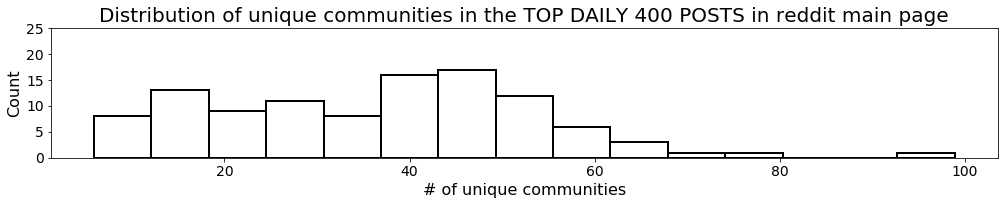

In [82]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
flierprops = dict(marker='o', markerfacecolor='white', markersize=8, linestyle='none', markeredgewidth = 1.5)
whiskerprops = dict(linewidth = 2, color = 'black')
capprops = dict(linewidth = 2, color = 'black')
medianprops = dict(linewidth = 2, color = 'black')

len(data_all.subreddit.unique())
len(data_all.loc[data_all.DayCount == 2].subreddit.unique())

grouped_df = data_all.groupby("DayCount")
grouped_df = grouped_df.agg({"subreddit": "nunique"})

grouped_df.hist(grid = False, figsize = (14,3), bins = 15,  align='left', color='white', edgecolor='black', linewidth=2)

plt.tight_layout()

plt.title('Distribution of unique communities in the TOP DAILY 400 POSTS in reddit main page', fontsize = 20)
plt.xlabel('# of unique communities', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(0,25)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.05)
plt.gcf().subplots_adjust(top=0.8)

plt.savefig('./num_of_subreddits_byday.png', dpi = 200)

data_all.shape
len(data_all.subreddit.unique())

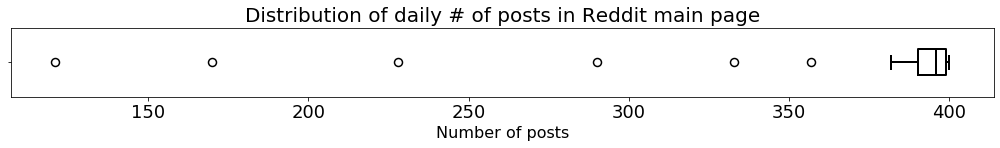

In [83]:
boxprops = dict(linestyle='-', linewidth=2, color='blue')
flierprops = dict(marker='o', markerfacecolor='white', markersize=8, linestyle='none', markeredgewidth = 1.5)
whiskerprops = dict(linewidth = 2, color = 'black')
capprops = dict(linewidth = 2, color = 'black')
medianprops = dict(linewidth = 2, color = 'black')

bp = pd.DataFrame({'':totals}).boxplot(grid = False, vert=False, figsize = (14,2), rot = 90, fontsize = 18,
                                       boxprops = boxprops, flierprops = flierprops, color = 'black',
                                       whiskerprops = whiskerprops, capprops = capprops,
                                       medianprops = medianprops,
                                       return_type='dict')

plt.tight_layout()
plt.title('Distribution of daily # of posts in Reddit main page', fontsize = 20)
plt.xlabel('Number of posts', fontsize = 16)
plt.ylim(0.8,1.2)
plt.gcf().subplots_adjust(bottom=0.32)
plt.gcf().subplots_adjust(top=0.8)
plt.savefig('./num_of_posts.png', dpi = 200)

Defining Events data frame

In [84]:
Events = {'first_EU_case' : 23.5,'is_pandemic' : 68.5, 'boris_in_hospital' : 94.5}

df_Events = pd.DataFrame({'event' : list(Events.keys()),
                          'day' : list(Events.values()),
                          'description' : ['First confirmed case \nin Europe (France)', # January 24
                                           #'WHO names the virus COVID-19', # February 11
                                           'WHO declares COVID-19 a pandemic', # March 10
                                           #'US bans flights from foreign countries', # March 11
                                           #'Lockdown starts in Denmark', # March 13
                                           'Boris Johnson is admitted\nto the Hospital']})
df_Events['y_text'] = [1,1, 1]
df_Events['y_tri_inv'] = 1
df_Events['y_tri'] = [1.5,1.5, 1.5]
df_Events['y_line'] = 1
df_Events

,event,day,description,y_text,y_tri_inv,y_tri,y_line
0,first_EU_case,23.5,First confirmed case \nin Europe (France),1,1,1.5,1
1,is_pandemic,68.5,WHO declares COVID-19 a pandemic,1,1,1.5,1
2,boris_in_hospital,94.5,Boris Johnson is admitted\nto the Hospital,1,1,1.5,1


Defining parameters that will be used in the plots

In [85]:
# https://javier.xyz/cohesive-colors/
days = list(range(106))
mc = ['#F93822', '#97B3D0','#58a4b0', '#DBB04A', '#ffd1d7', '#e6eeee']
columns = ['coronavirus','entertainment', 'humor','news/politics', 'educational', 'other']

output_notebook()

color_dict = dict(zip(columns, mc))

TOOLS = "hover,save,reset"
source = ColumnDataSource(data=data5_groups)


TOOLTIPS = [('',"@description")]
width_main = 1250

c_event = 'black'
w_event = 1.5
dash_event = 'dashed'

event_font_size = '12pt'
event_line1 = 1.12
event_line2 = 1.04


# User Based Content
ubc_dict = {**dict_pan, **dict_humor}
color_ubc = {'humor' : '#58a4b0', 'pan' : '#b5838d', 'other' : color_dict['other']}

Loading BokehJS ...

In [86]:
p = figure(plot_width=width_main, plot_height=340, title = None, x_range=(-0.5,105.5), y_range=(0,1), tools = "")


# r = p.varea_stack(columns, x='DayCount', color=mc, source=source, alpha = 1)
data_by_week = data5_groups
data_by_week = data_by_week.groupby(['DayCount']).mean().reset_index()
source_week = ColumnDataSource(data=data_by_week)
r = p.vbar_stack(columns, x='DayCount', width = 0.8, color=mc, source=source_week, alpha = 1)

 # Adjusting plot parameters
p.grid.visible = False
p.outline_line_color = "white"
p.background_fill_color = 'white'
p.background_fill_alpha = 1



for event in Events:
    y_event = df_Events[df_Events.event == event].y_line.values[0]
    day_event = df_Events[df_Events.event == event].day.values[0]
    p.line(x=[day_event, day_event], y = [0,y_event],
           line_color = c_event, line_width = w_event, line_dash = dash_event)


 # Adding event annotations
InvTri = InvertedTriangle(x="day", y="y_tri_inv", size=14, line_color=None, fill_color='black')
p.add_glyph(ColumnDataSource(data=df_Events), InvTri)  



# Adding event labels
event1 = Label(x=23, y=event_line1, text='First confirmed COVID-19', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
event11 = Label(x=23, y=event_line2, text='case in Europe', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
p.add_layout(event1)
p.add_layout(event11)

event2 = Label(x=68, y=event_line1, text='WHO declares', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
event21 = Label(x=68, y=event_line2, text='COVID-19 is a pandemic', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
p.add_layout(event2)
p.add_layout(event21)

event3 = Label(x=94, y=event_line1, text='UK PM admitted', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
event31 = Label(x=94, y=event_line2, text='to the hospital', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
p.add_layout(event3)
p.add_layout(event31)

# Creating 2020 arrow
start2020 = Label(x=4.5, y=0.9, text='2020', render_mode='css',
                    text_color = 'black', text_align = 'right',
                  text_font_style = 'bold', text_font_size = '20px')
p.add_layout(start2020)


arrow2020 = Arrow(end=NormalHead(size = 12),
                   x_start=3.8, y_start=0.95, x_end=3.8+2, y_end=0.95, line_width=0)
p.add_layout(arrow2020)

# Creating legend
legend_elements = []
for name,col in zip(columns,mc):
    r = p.square(x=[-1],y=[1], fill_color = col, line_color = None)
    legend_elements.append((name, [r]))
    
    
p.min_border_left = 110
p.min_border_left = 110
p.min_border_top = 50
p.min_border_bottom = 20

# Configuring axis
p.yaxis.visible = True
p.yaxis.axis_line_width = 2
p.yaxis.major_tick_line_width = 2
p.yaxis.axis_label = None
p.yaxis.ticker = [0,1]
p.yaxis.major_label_overrides = dict(zip([0,1],['0','100']))
p.yaxis.major_label_text_font_size = '16pt'
p.yaxis.axis_label_text_color = 'black'

x_ticks = df_Events.day.tolist()
x_ticks = [item for sublist in [[xi, xi+1] for xi in x_ticks] for item in sublist]

p.xaxis.visible = True
p.xaxis.axis_line_width = 2
p.xaxis.major_tick_line_width = 2
p.xaxis.ticker = [8.5,9.5] + x_ticks
p.xaxis.major_label_overrides = dict(zip([8.5,9.5]+x_ticks,['(1 day)','']+ ['24-Jan.', '','13-Mar.', '','06-Apr.','']))
p.xaxis.major_label_text_font_size = '16pt'
p.xaxis.major_label_text_baseline = 'bottom'
p.xaxis.major_label_standoff = 10
p.xaxis.major_label_text_color = 'black'

title_axis_y = 'Distribution of categories'
title_y1 = Label(x=-21.5, y=0.45, text=title_axis_y,
                render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = '18pt', angle = 90, angle_units = 'deg')
p.add_layout(title_y1)
title_axis_y2 = 'in reddit main page (%)'
title_y2 = Label(x=-18.35, y=0.42, text=title_axis_y2,
                render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = '18pt', angle = 90, angle_units = 'deg')
p.add_layout(title_y2)

## dummy plot with arrows
p_dummy = figure(plot_width=1250, plot_height=120, title = None, x_range=(0,105), y_range=(0,1), tools = "")
p_dummy.axis.visible = False
p_dummy.grid.visible = False
p_dummy.outline_line_color = None

x1 = 24
x2 = 69
x3 = 95

arrow1 = Arrow(end=NormalHead(size = 12),
                   x_start=x1, y_start=1, x_end=x1, y_end=0.1, line_width=2, line_color = 'black')
p_dummy.add_layout(arrow1)
p_dummy.line(x=[x1,x1], y = [1,0.1], line_width=2, line_color = 'black')

arrow2 = Arrow(end=NormalHead(size = 12),
                   x_start=x2, y_start=1, x_end=x2, y_end=0.1, line_width=2)
p_dummy.add_layout(arrow2)
p_dummy.line(x=[x2,x2], y = [1,0.1], line_width=2, line_color = 'black')

arrow3 = Arrow(end=NormalHead(size = 12),
                   x_start=x3, y_start=1, x_end=x3, y_end=0.1, line_width=2)
p_dummy.add_layout(arrow3)
p_dummy.line(x=[x3,x3], y = [1,0.1], line_width=2, line_color = 'black')

explanation = 'We could extract a random sample of\n100 posts from any of these days\nand get something like this...'
text1 = Text(x='x', y='y', text = 'text', text_font_size = '16pt', text_font = 'Helvetica', text_color = 'black')
p_dummy.add_glyph(ColumnDataSource(data=pd.DataFrame({'x':[(x1+x2)/3], 'y':[0.24], 'text':[explanation]})), text1)

p1 = CreateOneTiledPlot(24, tooltips=None)
p2 = CreateOneTiledPlot(70, tooltips=None)
p3 = CreateOneTiledPlot(96, tooltips=None)

space1 = Spacer(width=280, height=1)
space2 = Spacer(width=290, height=1)
space3 = Spacer(width=85, height=1)

first_plot = layout([[gridplot([p,p_dummy], ncols=1)],
             [space1, p1, space2, p2, space3, p3]])
show(first_plot)

# show(gridplot([p,p_dummy], ncols=1))

In [ ]:
script_ts, div_ts = components(first_plot)
f1 = open('./final/first_plot.html', 'w')
f1.write(script_ts)
f1.close()

f2 = open('./final/first_plot_div.html', 'w')
f2.write(div_ts)
f2.close()

# Face it

In [87]:
items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

rngsize = 10
TOOLS = "hover,save,reset"

List_of_plots = []
entertainment_communities = ['movies', 'television', 'sports']
news_communities = ['worldnews', 'news', 'politics']
edu_communities = ['science', 'technology', 'economics']

communities_to_plot = entertainment_communities + news_communities + edu_communities

for indx,i in enumerate(communities_to_plot):
    
    p = figure(plot_width=int(width_main/3), plot_height=130,x_range=(0,105), y_range=(0,1),
               tools = "", title = 'r/'+ str(i))
    
    df_ts = GetDF(sr=i,folder='days')
    
    df_ts['first_EU_case'] = [3*int(x>=24)-1 for x in range(df_ts.shape[0])]
    df_ts['is_pandemic'] = [3*int(x>=69)-1 for x in range(df_ts.shape[0])]
    df_ts['boris_in_hospital'] = [3*int(x>=95)-1 for x in range(df_ts.shape[0])]
    
    source = ColumnDataSource(data=df_ts)
    
#     p.varea(y1='f',y2='zero', x='timestep', color=mc[0], source=source, alpha = 1)
    color_bars = [color_dict['coronavirus'],color_dict[dictionaries[i]]]
    columns_bars = ['f','nf']
    r = p.vbar_stack(columns_bars, x='timestep', width = 0.6, color=color_bars, source=source, alpha = 1)
    
    for event in Events:
        y_event = df_Events[df_Events.event == event].y_line.values[0]
        day_event = df_Events[df_Events.event == event].day.values[0]
        p.line(x=[day_event, day_event], y = [0,y_event],
               line_color = c_event, line_width = w_event, line_dash = dash_event)


    
    # Adjusting plot parameters
    #p.x_range.range_padding = 0.05
    p.xaxis.axis_label = ""
    p.yaxis.axis_label = ""
    #p.yaxis.visible = False
    p.xaxis.visible = False
    p.yaxis.visible = True
    p.yaxis.axis_line_width = 2
    p.yaxis.ticker = []
    p.title.text_color = 'black'
    p.title.text_font_size = '16pt'
    p.grid.visible = False
    p.background_fill_color = 'white'
    p.background_fill_alpha = 1
    
    InvTri = InvertedTriangle(x="day", y="y_tri_inv", size=12, line_color=None, fill_color='black')
    p.add_glyph(ColumnDataSource(data=df_Events), InvTri)  
        
    List_of_plots.append(p)
    
    
p_all = gridplot(List_of_plots, ncols=3)

show(p_all)

In [ ]:
script_ts, div_ts = components(p_all)
f1 = open('./final/second_plot.html', 'w')
f1.write(script_ts)
f1.close()

f2 = open('./final/second_plot_div.html', 'w')
f2.write(div_ts)
f2.close()

# Learn from it

In [88]:
#https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

TOOLS = "hover,save,reset"
#TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

List_of_plots = []
N = 100
for week_counter in range(105):

    data_i = GetData(week_counter, 'worldnews', folder='days', categories = dictionaries)
    data_i = data_i.sample(N)

    all_categories = []
    for c in data_i.subreddit.tolist():
        new_c = c.lower()
        if c.lower() in dictionaries.keys():
            new_c = dictionaries[new_c]
        else:
            new_c = 'other'
        all_categories.append(new_c)

    Titles = data_i.title.tolist()
    date_i = data_i.date_char.tolist()
    time_of_post = data_i.time_utc.tolist()

    df = pd.DataFrame(list(zip(all_categories,Titles, time_of_post)), columns = ['cat','title', 'timepost'])

    df['col'] = [color_dict[cat] for cat in df.cat.tolist()]
    df['F'] = df.title.apply(CovidRelated)
    df.loc[df.F > 0,'col'] = color_dict['coronavirus']
    df = df.sort_values(by=['cat'])

    df.head()


    rngsize = int(np.sqrt(N))
    axis_range = [str(n) for n in range(rngsize)]
    X, Y = np.meshgrid(range(rngsize), range(rngsize))
    x_ = [item+0.5 for sublist in X for item in sublist]
    y_ = [item+0.5 for sublist in Y for item in sublist]

    df['x'] = x_
    df['y'] = y_

    # # NO TITLE
    edgesize = 150
    p_i = figure(x_range=axis_range, y_range=axis_range,
               x_axis_location="above", plot_width=edgesize, plot_height=edgesize,
               tools=TOOLS, toolbar_location='below',tooltips=[('title', '@title')])

    p_i.axis.visible = False
    p_i.rect(x="x", y="y", width=1, height=1,
           source=df,
           fill_color='col',#{'field': 'cat', 'transform': mapper},
           line_color='white', line_width = 1.2)
    
    if week_counter == 0:
        p_i.outline_line_color = 'black'
        p_i.outline_line_width = 4
        day1 = Label(x=0.5, y=10.3, text='Day 1', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
        p_i.add_layout(day1)


    List_of_plots.append(p_i)


output_notebook()

p_all3 = gridplot(List_of_plots, ncols=10)

show(p_all3)

Loading BokehJS ...

In [ ]:
script_ts, div_ts = components(p_all3)
f1 = open('./final/third_plot.html', 'w')
f1.write(script_ts)
f1.close()

f2 = open('./final/third_plot_div.html', 'w')
f2.write(div_ts)
f2.close()

# Adapt

In [89]:
List_of_DFs = [GetData(w,'all',folder='days') for w in range(106)]   
data_all = pd.concat(List_of_DFs)
data_by_subreddit = pd.pivot_table(data_all, index=['DayCount'], aggfunc='size', columns=['subreddit']).fillna(0)
totals = data_by_subreddit.sum(axis=1)
data_by_subreddit = data_by_subreddit.divide(totals, axis=0) # finding the probabilities

data_groups = data_by_subreddit.groupby(dictionaries, axis = 1).sum()
data_groups['other'] = 1 - data_groups.sum(axis=1)
data_groups['cor_edu_ent_news'] = data_groups[['coronavirus','educational', 'entertainment', 'news/politics']].sum(axis=1)

data_groups_fun = data_by_subreddit.groupby(ubc_dict, axis = 1).sum()
df2 = data_groups_fun.reset_index()

df2['humor'] = df2['humor'].div(data_groups['other'])
df2['pan'] = df2['pan'].div(data_groups['other'])

df2.head()

,DayCount,humor,pan
0,0,0.156250,0.0
1,1,0.454248,0.0
2,2,0.554140,0.0
3,3,0.510638,0.0
4,4,0.564356,0.0


In [90]:
TOOLS = "reset"


data_groups_fun = data_by_subreddit.groupby(ubc_dict, axis = 1).sum()


data3 = df2.reset_index()
ini_trend = 60
end_trend = 106
x1 = data3.DayCount.tolist()[ini_trend:end_trend]
y1 = data3['humor'].tolist()[ini_trend:end_trend]
smooth_points = lowess(exog = x1, endog = y1, frac = 0.3)
x1 = np.transpose(smooth_points)[0]
y1_smooth = np.transpose(smooth_points)[1]
# df2['humor_trend'] = [] + y1_smooth
df2['other'] = 1 - (df2['humor'] + df2['pan'])

yrange = (0,1)
xrange = (-0.5,105.5)
title = ''

p5 = figure(plot_width=width_main, plot_height=380, title = title, x_range=xrange, y_range=yrange, tools = TOOLS)

items = [] # items for legend
line = {} # bar-information for plotting

source = ColumnDataSource(data=df2)

p5.vbar_stack(list(color_ubc.keys()), x='DayCount', width = 0.8, color = list(color_ubc.values()), source = source, alpha = 1)
line['humor'] = p5.line(x=list(range(ini_trend,end_trend)), y=y1_smooth, line_width = 2, color = 'black')

items.append(('Humor trend', [line['humor']]))

y_event = 1
day_event = 76.5
p5.line(x=[day_event, day_event], y = [-2,4],line_color = c_event, line_width = w_event, line_dash = dash_event)
InvTri = InvertedTriangle(x=day_event, y=1, size=16, line_color=None, fill_color='black')
p5.add_glyph(InvTri)

step_box = pd.DataFrame({'x' : [0,day_event,day_event,106],
                         'y1' : [0,0,0,0],
                         'y2' : [0,0,1,1]})
p5.varea(x='x', y1 = 'y1', y2 = 'y2', source = ColumnDataSource(step_box), hatch_pattern = '/', hatch_alpha = 0.3, fill_color = None, hatch_scale = 30)
        
    
event1 = Label(x=day_event, y=event_line1, text='Lockdown starts', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
event11 = Label(x=day_event, y=event_line2, text='in NY city', render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = event_font_size)
p5.add_layout(event1)
p5.add_layout(event11)

    
p5.min_border_left = 110
p5.min_border_left = 110
p5.min_border_top = 50
p5.min_border_bottom = 20


 # Adjusting plot parameters
p5.grid.visible = False
p5.background_fill_color = "white"

legend = Legend(items=items)
p5.add_layout(legend, 'center')
p5.legend.orientation = "horizontal"
p5.legend.background_fill_color = None
p5.legend.background_fill_alpha = 0
p5.legend.border_line_width = 0
p5.legend.click_policy="hide"
p5.legend.label_text_font_size = '16pt'
p5.legend.label_standoff = 10

p5.yaxis.visible = True
p5.yaxis.axis_line_width = 2
p5.yaxis.major_tick_line_width = 2
p5.yaxis.axis_label = None
p5.yaxis.ticker = [0,1]
p5.yaxis.major_label_overrides = dict(zip([0,1],['0','100']))
p5.yaxis.major_label_text_font_size = '16pt'
p5.yaxis.axis_label_text_color = 'black'
p5.outline_line_color = None

p5.xaxis.visible = True
p5.xaxis.axis_line_width = 2
p5.xaxis.major_tick_line_width = 2
p5.xaxis.axis_label = None
p5.xaxis.ticker = [day_event, day_event+1]
p5.xaxis.major_label_overrides = dict(zip([day_event,day_event+1], ['18-Mar.','']))
p5.xaxis.major_label_text_font_size = '16pt'
p5.xaxis.major_label_text_baseline = 'bottom'
p5.xaxis.major_label_standoff = 10
p5.xaxis.major_label_text_color = 'black'


title_axis_y = 'Distribution inside'
title_y1 = Label(x=-17.5, y=0.28, text=title_axis_y,
                render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = '18pt', angle = 90, angle_units = 'deg')
p5.add_layout(title_y1)
title_axis_y2 = 'other category (%)'
title_y2 = Label(x=-15.6, y=0.30, text=title_axis_y2,
                render_mode='css', text_color = 'black', text_align = 'left',
               text_font_size = '18pt', angle = 90, angle_units = 'deg')
p5.add_layout(title_y2)

start2020 = Label(x=4.5, y=0.9, text='2020', render_mode='css',
                    text_color = 'black', text_align = 'right',
                  text_font_style = 'bold', text_font_size = '20px')
p5.add_layout(start2020)


arrow2020 = Arrow(end=NormalHead(size = 12),
                   x_start=3.8, y_start=0.941, x_end=3.8+2, y_end=0.941, line_width=0)
p5.add_layout(arrow2020)


# show(p5)


In [ ]:
from bokeh.embed import components

script, div = components(p5)
f1 = open('./final/last_plot.html', 'w')
f1.write(script)
f1.close()

f2 = open('./final/last_plot_div.html', 'w')
f2.write(div)
f2.close()

In [ ]:
items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

rngsize = 10
TOOLS = "hover,save,reset"

List_of_plots = []
communities_to_plot = ['humor', 'funny', 'memes']

for indx,i in enumerate(communities_to_plot):
    
    p6 = figure(plot_width=int(width_main/3), plot_height=130,x_range=(0,105), y_range=(0,1),
               tools = "", title = 'r/'+ str(i))
    
    df_ts = GetDF(sr=i,folder='days')
    
    df_ts['first_EU_case'] = [3*int(x>=24)-1 for x in range(df_ts.shape[0])]
    df_ts['is_pandemic'] = [3*int(x>=69)-1 for x in range(df_ts.shape[0])]
    df_ts['boris_in_hospital'] = [3*int(x>=95)-1 for x in range(df_ts.shape[0])]
    
    source = ColumnDataSource(data=df_ts)
    
    color_covid = color_dict['coronavirus']
    color_category = color_ubc['humor']
    color_bars = [color_covid,color_category]
    columns_bars = ['f','nf']
    r = p6.vbar_stack(columns_bars, x='timestep', width = 0.6, color=color_bars, source=source, alpha = 1)
    
    for event in Events:
        y_event = df_Events[df_Events.event == event].y_line.values[0]
        day_event = df_Events[df_Events.event == event].day.values[0]
        p6.line(x=[day_event, day_event], y = [0,y_event],
               line_color = c_event, line_width = w_event, line_dash = dash_event)


    
    # Adjusting plot parameters
    p6.xaxis.axis_label = ""
    p6.yaxis.axis_label = ""
    p6.xaxis.visible = False
    p6.yaxis.visible = True
    p6.yaxis.axis_line_width = 2
    p6.yaxis.ticker = []
    p6.title.text_color = 'black'
    p6.title.text_font_size = '16pt'
    p6.grid.visible = False
    p6.background_fill_color = 'white'
    p6.background_fill_alpha = 1
    
    InvTri = InvertedTriangle(x="day", y="y_tri_inv", size=12, line_color=None, fill_color='black')
    p6.add_glyph(ColumnDataSource(data=df_Events), InvTri)  
        
    List_of_plots.append(p6)
    
    
p_last = gridplot(List_of_plots, ncols=3)

In [12]:
script, div = components(p_last)
f1 = open('./final/almost_last_plot.html', 'w')
f1.write(script)
f1.close()

f2 = open('./final/almost_last_plot_div.html', 'w')
f2.write(div)
f2.close()